#Importing Adult dataset and preprocessing

In [ ]:
import pandas as pd

# Load directly from UCI repository URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race",
    "sex", "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]

train_data = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
train_data['income'] = train_data['income'].str.rstrip('.')
train_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
attributes_to_ignore = ['capital-gain','capital-loss']     # attributes with unique values such as names and ids that dont hold any information for the data and make learning harder
discrete_columns = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country','income']
train_data = train_data.drop(attributes_to_ignore, axis = 1)
train_data = train_data.dropna()
train_data = train_data.reset_index(drop=True)

In [ ]:
def rename_categorical_values(df):
    df = df.copy()  # Avoid modifying original DataFrame
    for col in df.select_dtypes(include=['object', 'category']).columns:
        unique_vals = df[col].unique()
        for val in unique_vals:
            if isinstance(val, str):
                # Find if this value exists in multiple columns
                count = sum((df[c] == val).any() for c in df.select_dtypes(include=['object', 'category']).columns)
                if count > 1:
                    df[col] = df[col].replace(val, f"{val}_{col}")
    return df

train_data = rename_categorical_values(train_data)

In [ ]:
attributes_to_ignore = ['capital-gain','capital-loss']     # attributes with unique values such as names and ids that dont hold any information for the data and make learning harder
discrete_columns = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country','income']
train_data = train_data.drop(attributes_to_ignore, axis = 1)
train_data = train_data.dropna()
train_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K


# upload custom dataset

In [ ]:
from google.colab import files

files.upload()      # Upload the training data csv. The following implementation drops the null values. Custom handling before uploading is encouraged
dataset_name = ''      # use the name .csv file imported above
attributes_to_ignore = ['...']     # attributes with unique values such as names and ids that dont hold any information for the data and make learning harder
discrete_columns = ['...']

In [ ]:
import pandas as pd

train_data = pd.read_csv(dataset_name)
train_data = train_data.dropna()
train_data = train_data.drop(attributes_to_ignore, axis = 1)
train_data.head()

,Team,Number,Position,Age,Height,Weight,College,Salary
0,Boston Celtics,0.0,PG,25.0,6-2,180.0,Texas,7730337.0
1,Boston Celtics,99.0,SF,25.0,6-6,235.0,Marquette,6796117.0
3,Boston Celtics,28.0,SG,22.0,6-5,185.0,Georgia State,1148640.0
6,Boston Celtics,55.0,PF,21.0,6-8,235.0,LSU,1170960.0
7,Boston Celtics,41.0,C,25.0,7-0,238.0,Gonzaga,2165160.0


# Step evaluation functions

In [ ]:
from scipy.stats import wasserstein_distance


def get_cat_wasserstein_distances(real_data, ctgan_data, column_name):
        real_rel = real_data.groupby(column_name).size().values
        total = sum(real_rel)
        real_rel = real_rel/total

        ctgan_rel = ctgan_data.groupby(column_name).size().values
        total = sum(ctgan_rel)
        ctgan_rel = ctgan_rel/total

        ctgan_distance = wasserstein_distance(real_rel, ctgan_rel)

        return ctgan_distance

In [ ]:
def avg_cat_w_dist(real_data, ctgan_data, discrete_columns):
    dists = 0
    for c in discrete_columns:
        dists += get_cat_wasserstein_distances(real_data, ctgan_data, c)
    avg_dists = dists/len(discrete_columns)
    return avg_dists

In [ ]:
from scipy.stats import wasserstein_distance

def avg_num_w_dist(real_data, model_data, numerical_columns):
    dists = 0
    for c in numerical_columns:
        dists += wasserstein_distance(real_data[c], model_data[c])
    avg_dists = dists/len(numerical_columns)
    return avg_dists

In [ ]:
import numpy as np

def L2_of_numerical_correlation_matrices(real_data, model_data, cols):
        # Compute correlation matrices
        df1 = real_data[cols]
        df2 = model_data[cols]
        corr1 = df1[cols].corr().values
        corr2 = df2[cols].corr().values

        # Compute the L2 (Euclidean) distance between the flattened matrices
        l2_distance = np.linalg.norm(corr1 - corr2)

        return l2_distance



# CTGAN Synthesizer

In [ ]:
#upload the 'transformer.py' and 'data_sampler.py'
from google.colab import files
files.upload()

In [ ]:
!pip install rdt tqdm

In [ ]:
# Implementation of the CTGAN synthesizer
# GitHub repository: https://github.com/sdv-dev/CTGAN
# Paper: https://arxiv.org/abs/1907.00503


"""CTGAN module."""

import warnings
import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import BatchNorm1d, Dropout, LeakyReLU, Linear, Module, ReLU, Sequential, functional
from tqdm import tqdm

from data_sampler import DataSampler
from transformer import DataTransformer



class Discriminator(Module):
    """Discriminator for the CTGAN."""

    def __init__(self, input_dim, discriminator_dim, pac=10):
        super(Discriminator, self).__init__()
        dim = input_dim * pac
        self.pac = pac
        self.pacdim = dim
        seq = []
        for item in list(discriminator_dim):
            seq += [Linear(dim, item), LeakyReLU(0.2), Dropout(0.5)]
            dim = item

        seq += [Linear(dim, 1)]
        self.seq = Sequential(*seq) # The * in *seq is used to unpack the list seq to create the sequential model

    def calc_gradient_penalty(self, real_data, fake_data, device='cpu', pac=10, lambda_=10):
        """Compute the gradient penalty."""
        alpha = torch.rand(real_data.size(0) // pac, 1, 1, device=device)
        alpha = alpha.repeat(1, pac, real_data.size(1))
        alpha = alpha.view(-1, real_data.size(1))   #These three lines created an array with repeating values between 0 and 1 for interpolation

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)

        disc_interpolates = self(interpolates)   #This returns the output of the discriminator with interpolates as input. Thats because this class comes from NNModule wcich calls "forward" automatically

        gradients = torch.autograd.grad(
            outputs=disc_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones(disc_interpolates.size(), device=device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        gradients_view = gradients.view(-1, pac * real_data.size(1)).norm(2, dim=1) - 1
        gradient_penalty = ((gradients_view) ** 2).mean() * lambda_

        return gradient_penalty

    def forward(self, input_):
        """Apply the Discriminator to the `input_`."""
        assert input_.size()[0] % self.pac == 0
        return self.seq(input_.view(-1, self.pacdim)) #This ensures the forward passing through the torch.nn.Sequential model defined in _init_


class Residual(Module):
    """Residual layer for the CTGAN."""

    def __init__(self, i, o):
        super(Residual, self).__init__()
        self.fc = Linear(i, o)
        self.bn = BatchNorm1d(o)
        self.relu = ReLU()

    def forward(self, input_):
        """Apply the Residual layer to the `input_`."""
        out = self.fc(input_)
        out = self.bn(out)
        out = self.relu(out)
        return torch.cat([out, input_], dim=1)


class Generator(Module):
    """Generator for the CTGAN."""

    def __init__(self, embedding_dim, generator_dim, data_dim):
        super(Generator, self).__init__()
        dim = embedding_dim
        seq = []
        for item in list(generator_dim):
            seq += [Residual(dim, item)]
            dim += item
        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)

    def forward(self, input_):
        """Apply the Generator to the `input_`."""
        data = self.seq(input_)
        return data


class CTGAN(): #(BaseSynthesizer)
    """Conditional Table GAN Synthesizer.

    This is the core class of the CTGAN project, where the different components
    are orchestrated together.
    For more details about the process, please check the [Modeling Tabular data using
    Conditional GAN](https://arxiv.org/abs/1907.00503) paper.

    Args:
        embedding_dim (int):
            Size of the random sample passed to the Generator. Defaults to 128.
        generator_dim (tuple or list of ints):
            Size of the output samples for each one of the Residuals. A Residual Layer
            will be created for each one of the values provided. Defaults to (256, 256).
        discriminator_dim (tuple or list of ints):
            Size of the output samples for each one of the Discriminator Layers. A Linear Layer
            will be created for each one of the values provided. Defaults to (256, 256).
        generator_lr (float):
            Learning rate for the generator. Defaults to 2e-4.
        generator_decay (float):
            Generator weight decay for the Adam Optimizer. Defaults to 1e-6.
        discriminator_lr (float):
            Learning rate for the discriminator. Defaults to 2e-4.
        discriminator_decay (float):
            Discriminator weight decay for the Adam Optimizer. Defaults to 1e-6.
        batch_size (int):
            Number of data samples to process in each step.
        discriminator_steps (int):
            Number of discriminator updates to do for each generator update.
            From the WGAN paper: https://arxiv.org/abs/1701.07875. WGAN paper
            default is 5. Default used is 1 to match original CTGAN implementation.
        log_frequency (boolean):
            Whether to use log frequency of categorical levels in conditional
            sampling. Defaults to ``True``.
        verbose (boolean):
            Whether to have print statements for progress results. Defaults to ``False``.
        epochs (int):
            Number of training epochs. Defaults to 300.
        pac (int):
            Number of samples to group together when applying the discriminator.
            Defaults to 10.
        cuda (bool):
            Whether to attempt to use cuda for GPU computation.
            If this is False or CUDA is not available, CPU will be used.
            Defaults to ``True``.
    """

    def __init__(
        self,
        embedding_dim=128,
        generator_dim=(512, 1024, 1024, 512),
        discriminator_dim=(512, 512),
        generator_lr=1e-5,
        generator_decay=1e-6,
        discriminator_lr=1e-5,
        discriminator_decay=1e-6,
        batch_size=4000,
        discriminator_steps=2,
        log_frequency=True,
        verbose=False,
        epochs=300,
        pac=10,
        cuda=True,
    ):
        assert batch_size % 2 == 0

        self._embedding_dim = embedding_dim
        self._generator_dim = generator_dim
        self._discriminator_dim = discriminator_dim

        self._generator_lr = generator_lr
        self._generator_decay = generator_decay
        self._discriminator_lr = discriminator_lr
        self._discriminator_decay = discriminator_decay

        self._batch_size = batch_size
        self._discriminator_steps = discriminator_steps
        self._log_frequency = log_frequency
        self._verbose = verbose
        self._epochs = epochs
        self.pac = pac

        if not cuda or not torch.cuda.is_available():
            device = 'cpu'
        elif isinstance(cuda, str):
            device = cuda
        else:
            device = 'cuda'

        self._device = torch.device(device)

        self._transformer = None
        self._data_sampler = None
        self._generator = None
        self.loss_values = None

    @staticmethod
    def _gumbel_softmax(logits, tau=1, hard=False, eps=1e-10, dim=-1):
        """Deals with the instability of the gumbel_softmax for older versions of torch.

        For more details about the issue:
        https://drive.google.com/file/d/1AA5wPfZ1kquaRtVruCd6BiYZGcDeNxyP/view?usp=sharing

        Args:
            logits […, num_features]:
                Unnormalized log probabilities
            tau:
                Non-negative scalar temperature
            hard (bool):
                If True, the returned samples will be discretized as one-hot vectors,
                but will be differentiated as if it is the soft sample in autograd
            dim (int):
                A dimension along which softmax will be computed. Default: -1.

        Returns:
            Sampled tensor of same shape as logits from the Gumbel-Softmax distribution.
        """
        for _ in range(10):
            transformed = functional.gumbel_softmax(logits, tau=tau, hard=hard, eps=eps, dim=dim)
            if not torch.isnan(transformed).any():
                return transformed

        raise ValueError('gumbel_softmax returning NaN.')

    def _apply_activate(self, data):
        """Apply proper activation function to the output of the generator."""
        data_t = []
        st = 0
        for column_info in self._transformer.output_info_list:
            for span_info in column_info:
                if span_info.activation_fn == 'tanh':
                    ed = st + span_info.dim
                    data_t.append(torch.tanh(data[:, st:ed]))
                    st = ed
                elif span_info.activation_fn == 'softmax':
                    ed = st + span_info.dim
                    transformed = self._gumbel_softmax(data[:, st:ed], tau=0.5)
                    data_t.append(transformed)
                    st = ed
                else:
                    raise ValueError(f'Unexpected activation function {span_info.activation_fn}.')

        return torch.cat(data_t, dim=1)

    def _cond_loss(self, data, c, m):
        """Compute the cross entropy loss on the fixed discrete column."""
        loss = []
        st = 0
        st_c = 0
        for column_info in self._transformer.output_info_list:
            for span_info in column_info:
                if len(column_info) != 1 or span_info.activation_fn != 'softmax':
                    # not discrete column
                    st += span_info.dim
                else:
                    ed = st + span_info.dim
                    ed_c = st_c + span_info.dim
                    tmp = functional.cross_entropy(
                        data[:, st:ed], torch.argmax(c[:, st_c:ed_c], dim=1), reduction='none'
                    )
                    loss.append(tmp)
                    st = ed
                    st_c = ed_c

        loss = torch.stack(loss, dim=1)  # noqa: PD013

        return (loss * m).sum() / data.size()[0]

    def _validate_discrete_columns(self, train_data, discrete_columns):
        """Check whether ``discrete_columns`` exists in ``train_data``.

        Args:
            train_data (numpy.ndarray or pandas.DataFrame):
                Training Data. It must be a 2-dimensional numpy array or a pandas.DataFrame.
            discrete_columns (list-like):
                List of discrete columns to be used to generate the Conditional
                Vector. If ``train_data`` is a Numpy array, this list should
                contain the integer indices of the columns. Otherwise, if it is
                a ``pandas.DataFrame``, this list should contain the column names.
        """
        if isinstance(train_data, pd.DataFrame):
            invalid_columns = set(discrete_columns) - set(train_data.columns)
        elif isinstance(train_data, np.ndarray):
            invalid_columns = []
            for column in discrete_columns:
                if column < 0 or column >= train_data.shape[1]:
                    invalid_columns.append(column)
        else:
            raise TypeError('``train_data`` should be either pd.DataFrame or np.array.')

        if invalid_columns:
            raise ValueError(f'Invalid columns found: {invalid_columns}')

    def _validate_null_data(self, train_data, discrete_columns):
        """Check whether null values exist in continuous ``train_data``.

        Args:
            train_data (numpy.ndarray or pandas.DataFrame):
                Training Data. It must be a 2-dimensional numpy array or a pandas.DataFrame.
            discrete_columns (list-like):
                List of discrete columns to be used to generate the Conditional
                Vector. If ``train_data`` is a Numpy array, this list should
                contain the integer indices of the columns. Otherwise, if it is
                a ``pandas.DataFrame``, this list should contain the column names.
        """
        if isinstance(train_data, pd.DataFrame):
            continuous_cols = list(set(train_data.columns) - set(discrete_columns))
            any_nulls = train_data[continuous_cols].isna().any().any()
        else:
            continuous_cols = [i for i in range(train_data.shape[1]) if i not in discrete_columns]
            any_nulls = pd.DataFrame(train_data)[continuous_cols].isna().any().any()

        if any_nulls:
            raise ValueError(
                'CTGAN does not support null values in the continuous training data. '
                'Please remove all null values from your continuous training data.'
            )

    #random_state
    def fit(self, train_data, discrete_columns=(), epochs=None):
        """Fit the CTGAN Synthesizer models to the training data.

        Args:
            train_data (numpy.ndarray or pandas.DataFrame):
                Training Data. It must be a 2-dimensional numpy array or a pandas.DataFrame.
            discrete_columns (list-like):
                List of discrete columns to be used to generate the Conditional
                Vector. If ``train_data`` is a Numpy array, this list should
                contain the integer indices of the columns. Otherwise, if it is
                a ``pandas.DataFrame``, this list should contain the column names.
        """
        self._validate_discrete_columns(train_data, discrete_columns)
        self._validate_null_data(train_data, discrete_columns)

        train_df = train_data.copy()
        self.avg_cat_w_distances = []
        self.avg_num_w_distances = []
        self.corr_l2_distances = []
        num_columns = [c for c in train_df.columns if c not in discrete_columns]

        if epochs is None:
            epochs = self._epochs
        else:
            warnings.warn(
                (
                    '`epochs` argument in `fit` method has been deprecated and will be removed '
                    'in a future version. Please pass `epochs` to the constructor instead'
                ),
                DeprecationWarning,
            )

        self._transformer = DataTransformer()
        self._transformer.fit(train_data, discrete_columns)

        train_data = self._transformer.transform(train_data)

        self._data_sampler = DataSampler(
            train_data, self._transformer.output_info_list, self._log_frequency
        )

        data_dim = self._transformer.output_dimensions

        self._generator = Generator(
            self._embedding_dim + self._data_sampler.dim_cond_vec(), self._generator_dim, data_dim
        ).to(self._device)

        discriminator = Discriminator(
            data_dim + self._data_sampler.dim_cond_vec(), self._discriminator_dim, pac=self.pac
        ).to(self._device)

        optimizerG = optim.Adam(
            self._generator.parameters(),
            lr=self._generator_lr,
            betas=(0.5, 0.9),
            weight_decay=self._generator_decay,
        )

        optimizerD = optim.Adam(
            discriminator.parameters(),
            lr=self._discriminator_lr,
            betas=(0.5, 0.9),
            weight_decay=self._discriminator_decay,
        )

        mean = torch.zeros(self._batch_size, self._embedding_dim, device=self._device)
        std = mean + 1

        self.loss_values = pd.DataFrame(columns=['Epoch', 'Generator Loss', 'Distriminator Loss'])

        epoch_iterator = tqdm(range(epochs), disable=(not self._verbose))
        if self._verbose:
            description = 'Gen. ({gen:.2f}) | Discrim. ({dis:.2f})'
            epoch_iterator.set_description(description.format(gen=0, dis=0))

        steps_per_epoch = max(len(train_data) // self._batch_size, 1)
        for i in epoch_iterator:
            for id_ in range(steps_per_epoch):
                for n in range(self._discriminator_steps):
                    fakez = torch.normal(mean=mean, std=std) #gives a scalar sampled from normal distribution with mean=mean and std=std

                    condvec = self._data_sampler.sample_condvec(self._batch_size) #returns _batch_size number of results of (cond vector, mask vector, ids of the discrete columns, category in each discrete column)
                    if condvec is None:
                        c1, m1, col, opt = None, None, None, None
                        real = self._data_sampler.sample_data(
                            train_data, self._batch_size, col, opt
                        )
                    else:
                        c1, m1, col, opt = condvec
                        c1 = torch.from_numpy(c1).to(self._device)
                        m1 = torch.from_numpy(m1).to(self._device)
                        fakez = torch.cat([fakez, c1], dim=1) #fakez is a tensor starting with a random float and then the cond vector c1

                        perm = np.arange(self._batch_size)
                        np.random.shuffle(perm)
                        #sample_data samples batch_size rows from the real data. The rows' discrete columns match the cond vectors sampled in sample_condvec
                        real = self._data_sampler.sample_data(
                            train_data, self._batch_size, col[perm], opt[perm] #Col is an integer representation of mask and contains batch number of column ids, opt contains the corresponding chosen category of each column
                        )
                        c2 = c1[perm]

                    fake = self._generator(fakez)
                    fakeact = self._apply_activate(fake)

                    real = torch.from_numpy(real.astype('float32')).to(self._device)

                    if c1 is not None:
                        fake_cat = torch.cat([fakeact, c1], dim=1)
                        real_cat = torch.cat([real, c2], dim=1)
                    else:
                        real_cat = real
                        fake_cat = fakeact

                    y_fake = discriminator(fake_cat)
                    y_real = discriminator(real_cat)

                    pen = discriminator.calc_gradient_penalty(
                        real_cat, fake_cat, self._device, self.pac
                    )
                    loss_d = -(torch.mean(y_real) - torch.mean(y_fake))

                    optimizerD.zero_grad(set_to_none=False)
                    pen.backward(retain_graph=True)
                    loss_d.backward()
                    optimizerD.step() #updates the dicriminator by applying the accumulated gradients from pen.backward and loss_d.backward

                fakez = torch.normal(mean=mean, std=std)
                condvec = self._data_sampler.sample_condvec(self._batch_size)

                if condvec is None:
                    c1, m1, col, opt = None, None, None, None
                else:
                    c1, m1, col, opt = condvec
                    c1 = torch.from_numpy(c1).to(self._device)
                    m1 = torch.from_numpy(m1).to(self._device)
                    fakez = torch.cat([fakez, c1], dim=1)

                fake = self._generator(fakez)
                fakeact = self._apply_activate(fake)

                if c1 is not None:
                    y_fake = discriminator(torch.cat([fakeact, c1], dim=1))
                else:
                    y_fake = discriminator(fakeact)

                if condvec is None:
                    cross_entropy = 0
                else:
                    cross_entropy = self._cond_loss(fake, c1, m1)

                loss_g = -torch.mean(y_fake) + cross_entropy

                optimizerG.zero_grad(set_to_none=False)
                loss_g.backward()
                optimizerG.step()

            generator_loss = loss_g.detach().cpu().item()
            discriminator_loss = loss_d.detach().cpu().item()

            if i%10==0:
              print(f"Gen Loss: {generator_loss}, Disc Loss: {discriminator_loss}")

              curr_samples = self.sample(1000)
              self.avg_cat_w_distances.append(avg_cat_w_dist(train_df, curr_samples, discrete_columns))
              self.avg_num_w_distances.append(avg_num_w_dist(train_df, curr_samples, num_columns))
              self.corr_l2_distances.append(L2_of_numerical_correlation_matrices(train_df, curr_samples, num_columns))


            epoch_loss_df = pd.DataFrame({
                'Epoch': [i],
                'Generator Loss': [generator_loss],
                'Discriminator Loss': [discriminator_loss],
            })
            if not self.loss_values.empty:
                self.loss_values = pd.concat([self.loss_values, epoch_loss_df]).reset_index(
                    drop=True
                )
            else:
                self.loss_values = epoch_loss_df

            if self._verbose:
                epoch_iterator.set_description(
                    description.format(gen=generator_loss, dis=discriminator_loss)
                )

        return self.avg_cat_w_distances, self.avg_num_w_distances, self.corr_l2_distances

    #random_state
    def sample(self, n, condition_column=None, condition_value=None):
        """Sample data similar to the training data.

        Choosing a condition_column and condition_value will increase the probability of the
        discrete condition_value happening in the condition_column.

        Args:
            n (int):
                Number of rows to sample.
            condition_column (string):
                Name of a discrete column.
            condition_value (string):
                Name of the category in the condition_column which we wish to increase the
                probability of happening.

        Returns:
            numpy.ndarray or pandas.DataFrame
        """
        if condition_column is not None and condition_value is not None:
            condition_info = self._transformer.convert_column_name_value_to_id(
                condition_column, condition_value
            )
            global_condition_vec = self._data_sampler.generate_cond_from_condition_column_info(
                condition_info, self._batch_size
            )
        else:
            global_condition_vec = None

        steps = n // self._batch_size + 1
        data = []
        for i in range(steps):
            mean = torch.zeros(self._batch_size, self._embedding_dim)
            std = mean + 1
            fakez = torch.normal(mean=mean, std=std).to(self._device)

            if global_condition_vec is not None:
                condvec = global_condition_vec.copy()
            else:
                condvec = self._data_sampler.sample_original_condvec(self._batch_size)

            if condvec is None:
                pass
            else:
                c1 = condvec
                c1 = torch.from_numpy(c1).to(self._device)
                fakez = torch.cat([fakez, c1], dim=1)

            fake = self._generator(fakez)
            fakeact = self._apply_activate(fake)
            data.append(fakeact.detach().cpu().numpy())

        data = np.concatenate(data, axis=0)
        data = data[:n]

        return self._transformer.inverse_transform(data)

    def set_device(self, device):
        """Set the `device` to be used ('GPU' or 'CPU)."""
        self._device = device
        if self._generator is not None:
            self._generator.to(self._device)

#Training

In [ ]:
ctgan = CTGAN()

res = ctgan.fit(train_data, discrete_columns)

#Generating progession graphs

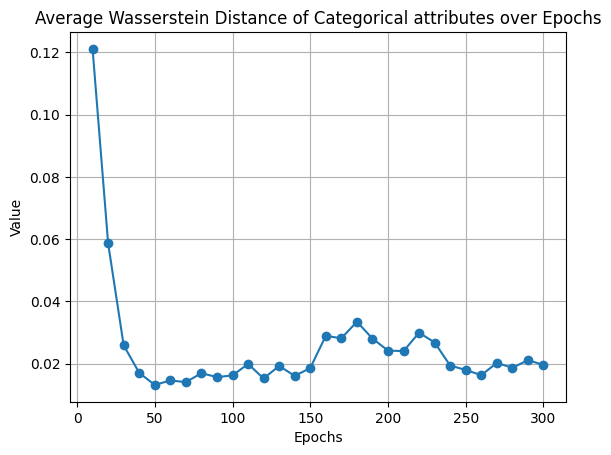

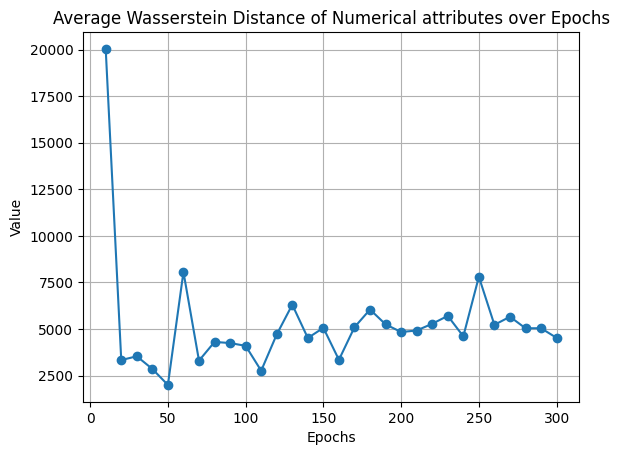

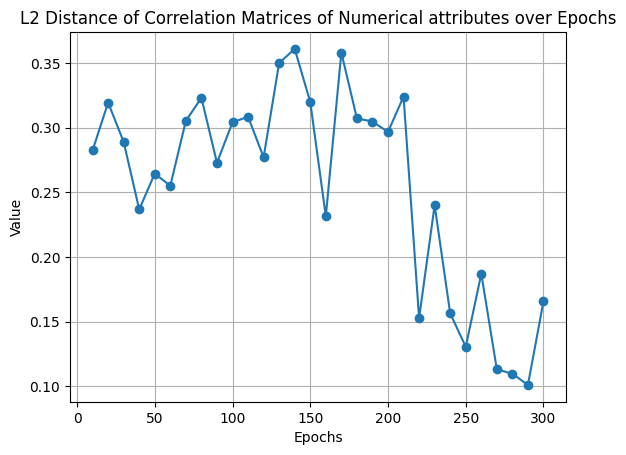

In [ ]:
import matplotlib.pyplot as plt

values = res[0]
epochs = [10 * (i + 1) for i in range(len(values))]

# Plot
plt.plot(epochs, values, marker='o')
plt.title("Average Wasserstein Distance of Categorical attributes over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()

values = res[1]
epochs = [10 * (i + 1) for i in range(len(values))]

# Plot
plt.plot(epochs, values, marker='o')
plt.title("Average Wasserstein Distance of Numerical attributes over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()

values = res[2]
epochs = [10 * (i + 1) for i in range(len(values))]

# Plot
plt.plot(epochs, values, marker='o')
plt.title("L2 Distance of Correlation Matrices of Numerical attributes over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()

#Sampling and saving

In [ ]:
samples = ctgan.sample(5000)

In [ ]:
samples

In [ ]:
samples.to_csv('ctgan_samples.csv')
files.download('ctgan_samples.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>